In [1]:
import re
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train = pd.read_csv('C:/Users/LENOVO/Downloads/train/train.csv')

In [3]:
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [4]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [5]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


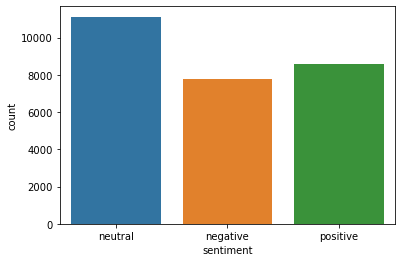

In [6]:
# Check for data imbalance
sns.countplot(train["sentiment"]);

# Data cleaning

In [7]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [8]:
#Is there any null value?
train["selected_text"].isnull().sum()

1

In [9]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)

In [10]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [11]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [13]:
len(data_words)

27481

In [14]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [15]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [16]:
data = np.array(data)

# Label encoding

In [17]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [18]:
len(labels)

27481

# Data sequencing and splitting

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [20]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [21]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


# Model building

# 1. SimpleRNN model

In [89]:
from keras.layers import Dropout

model0 = Sequential()
model0.add(layers.Embedding(max_words, 50))
model0.add(layers.SimpleRNN(50))
model0.add(Dropout(0.2))
model0.add(layers.Dense(3,activation='softmax'))


model0.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history = model0.fit(X_train, y_train, epochs=30)

Epoch 1/30
645/645 [==============================] - 17s 25ms/step - loss: 0.8271 - accuracy: 0.6333
Epoch 2/30
645/645 [==============================] - 18s 28ms/step - loss: 0.4066 - accuracy: 0.8534
Epoch 3/30
645/645 [==============================] - 21s 32ms/step - loss: 0.3317 - accuracy: 0.8821
Epoch 4/30
645/645 [==============================] - 21s 33ms/step - loss: 0.2579 - accuracy: 0.9102
Epoch 5/30
645/645 [==============================] - 21s 32ms/step - loss: 0.1965 - accuracy: 0.9328
Epoch 6/30
645/645 [==============================] - 21s 32ms/step - loss: 0.2364 - accuracy: 0.9171
Epoch 7/30
645/645 [==============================] - 21s 33ms/step - loss: 0.1503 - accuracy: 0.9468
Epoch 8/30
645/645 [==============================] - 21s 33ms/step - loss: 0.1562 - accuracy: 0.9441
Epoch 9/30
645/645 [==============================] - 21s 32ms/step - loss: 0.1182 - accuracy: 0.9587
Epoch 10/30
645/645 [==============================] - 21s 32ms/step - loss: 0.230

In [90]:
model0.evaluate(X_test,  y_test, verbose=2)

215/215 - 1s - loss: 1.1946 - accuracy: 0.7648


[1.1945754289627075, 0.7648085951805115]

In [78]:
yhat_classes = model0.predict_classes(X_test, verbose=0)

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [86]:
f1 = f1_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.750524


In [87]:
recall = recall_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('recall score: %f' % recall)

recall score: 0.751273


In [88]:
precision = precision_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('precision score: %f' % precision)

precision score: 0.762273


# 2. Single LSTM layer model

In [29]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(20))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(X_train, y_train, epochs=50)

Epoch 1/50
645/645 [==============================] - 27s 39ms/step - loss: 0.8695 - accuracy: 0.6221
Epoch 2/50
645/645 [==============================] - 25s 39ms/step - loss: 0.5030 - accuracy: 0.8042
Epoch 3/50
645/645 [==============================] - 27s 43ms/step - loss: 0.4337 - accuracy: 0.8346
Epoch 4/50
645/645 [==============================] - 28s 43ms/step - loss: 0.4056 - accuracy: 0.8477
Epoch 5/50
645/645 [==============================] - 27s 42ms/step - loss: 0.3828 - accuracy: 0.8584
Epoch 6/50
645/645 [==============================] - 27s 42ms/step - loss: 0.3644 - accuracy: 0.8665
Epoch 7/50
645/645 [==============================] - 27s 42ms/step - loss: 0.3499 - accuracy: 0.8703
Epoch 8/50
645/645 [==============================] - 29s 44ms/step - loss: 0.3425 - accuracy: 0.8770
Epoch 9/50
645/645 [==============================] - 27s 42ms/step - loss: 0.3341 - accuracy: 0.8797
Epoch 10/50
645/645 [==============================] - 28s 44ms/step - loss: 0.322

In [30]:
model1.evaluate(X_test,  y_test, verbose=2)

215/215 - 2s - loss: 0.6483 - accuracy: 0.8086


[0.6482827067375183, 0.8086159229278564]

In [31]:
yhat_classes = model1.predict_classes(X_test, verbose=0)

In [32]:
f1 = f1_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.808658


In [34]:
recall = recall_score(y_test.argmax(axis=1), yhat_classes,average='weighted')
print('recall score: %f' % recall)

recall score: 0.808616


In [36]:
precision = precision_score(y_test.argmax(axis=1),yhat_classes,average='weighted')
print('precision score: %f' % precision)

precision score: 0.809087


# 3. Bidirectional LTSM model

In [37]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=100)

Epoch 1/100
645/645 [==============================] - 43s 61ms/step - loss: 0.8354 - accuracy: 0.6292
Epoch 2/100
645/645 [==============================] - 45s 70ms/step - loss: 0.4870 - accuracy: 0.8103
Epoch 3/100
645/645 [==============================] - 45s 70ms/step - loss: 0.4122 - accuracy: 0.8494
Epoch 4/100
645/645 [==============================] - 45s 70ms/step - loss: 0.3867 - accuracy: 0.8584
Epoch 5/100
645/645 [==============================] - 45s 69ms/step - loss: 0.3730 - accuracy: 0.8643
Epoch 6/100
645/645 [==============================] - 45s 71ms/step - loss: 0.3521 - accuracy: 0.8730
Epoch 7/100
645/645 [==============================] - 45s 70ms/step - loss: 0.3441 - accuracy: 0.8748
Epoch 8/100
645/645 [==============================] - 45s 70ms/step - loss: 0.3325 - accuracy: 0.8784
Epoch 9/100
645/645 [==============================] - 45s 70ms/step - loss: 0.3256 - accuracy: 0.8818
Epoch 10/100
645/645 [==============================] - 45s 69ms/step - l

In [39]:
model2.evaluate(X_test,  y_test, verbose=2)

215/215 - 3s - loss: 1.2374 - accuracy: 0.7620


[1.2373535633087158, 0.7620433568954468]

In [40]:
yhat_classes = model2.predict_classes(X_test, verbose=0)

In [41]:
f1 = f1_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.761175


In [43]:
recall = recall_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('recall score: %f' % recall)

recall score: 0.762043


In [44]:
precision = precision_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('precision score: %f' % precision)

precision score: 0.764130


# 4. 1D Convolutional model

In [106]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

history = model3.fit(X_train, y_train, epochs=100)

Epoch 1/100
645/645 [==============================] - 7s 9ms/step - loss: 1.2714 - acc: 0.4534
Epoch 2/100
645/645 [==============================] - 6s 10ms/step - loss: 0.8750 - acc: 0.6070
Epoch 3/100
645/645 [==============================] - 7s 11ms/step - loss: 0.8238 - acc: 0.6278
Epoch 4/100
645/645 [==============================] - 7s 11ms/step - loss: 0.7561 - acc: 0.7159
Epoch 5/100
645/645 [==============================] - 8s 12ms/step - loss: 0.6271 - acc: 0.7881
Epoch 6/100
645/645 [==============================] - 8s 13ms/step - loss: 0.5454 - acc: 0.8226
Epoch 7/100
645/645 [==============================] - 7s 11ms/step - loss: 0.5332 - acc: 0.8269
Epoch 8/100
645/645 [==============================] - 8s 12ms/step - loss: 0.4983 - acc: 0.8438
Epoch 9/100
645/645 [==============================] - 6s 10ms/step - loss: 0.4898 - acc: 0.8438
Epoch 10/100
645/645 [==============================] - 8s 12ms/step - loss: 0.4682 - acc: 0.8549
Epoch 11/100
645/645 [========

In [107]:
model3.evaluate(X_test,  y_test, verbose=2)

215/215 - 1s - loss: 0.6607 - acc: 0.8189


[0.6606921553611755, 0.8189492225646973]

In [108]:
yhat_classes = model3.predict_classes(X_test, verbose=0)

In [109]:
f1 = f1_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.818884


In [110]:
recall = recall_score(y_tests, yhat_classes,average='weighted')
print('recall score: %f' % recall)

recall score: 0.818949


In [111]:
precision = precision_score(y_tests, yhat_classes,average='weighted')
print('precision score: %f' % precision)

precision score: 0.821187


The overall results are as below:

In [47]:
score = [('SimpleRNN model',0.75,0.75,.76),
('Single LSTM layer model',0.80,0.80,.80),
('Bidirectional LTSM model',0.76,0.76,.76),
('1D Convolutional model',0.81,0.81,0.82),
('CNN-LSTM',0.84,.84,0.84)]
label=['Classifier','F1 Score', 'Recall_score','Precision_']

score_df = pd.DataFrame(data=score, columns=label)#.set_index('Classifier')
score_df

,Classifier,F1 Score,Recall_score,Precision_
0,SimpleRNN model,0.75,0.75,0.76
1,Single LSTM layer model,0.80,0.80,0.80
2,Bidirectional LTSM model,0.76,0.76,0.76
3,1D Convolutional model,0.81,0.81,0.82
4,CNN-LSTM,0.84,0.84,0.84


# Best model validation

(Before final commit, the best model obtained was the CNN-LSTM)

In [114]:
predictions = model2.predict(X_test)

In [115]:
sentiment = ['Neutral','Negative','Positive']

In [117]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [123]:
sequence = tokenizer.texts_to_sequences(['i fucking hate you'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'